## Introduction
####  Build a  Machine Learning model to classify each language on the basis on their extinction probability.

### Import the necessary packages.

In [145]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler,PolynomialFeatures

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import train and test dataset

In [175]:
train=pd.read_csv("/content/gdrive/MyDrive/data-sprint-67-probability-of-language-extinction/train_dataset.csv")
test=pd.read_csv("/content/gdrive/MyDrive/data-sprint-67-probability-of-language-extinction/test_dataset.csv")

### Structure of the train and test dataset.

In [ ]:
train.shape

(1905, 508)

In [ ]:
for i ,col in enumerate(train.columns):
  print(f"{i}_{col}")

#### The above information shows that there are 1905 data entries and 508 columns.

#### The target column is **Degree of endangerment**.

In [ ]:
test.shape

(817, 507)

#### The above information shows that there are 817 data entries and 507 columns.

#### Let's see is there any missing values in train and test dataset by column wise.

In [134]:
train.columns[train.isnull().any()]

Index([], dtype='object')

#### The above information shows that there are no missing values..

In [135]:
test.columns[test.isnull().any()]

Index([], dtype='object')

#### The above information shows that there are no missing values..

#### Let's see the glimpse of train dataset

In [196]:
train.head(2)

,Number of speakers,Latitude,Longitude,Afghanistan,"Albania, Algeria, Bosnia and Herzegovina, Bulgaria, Croatia, Greece, The former Yugoslav Republic of Macedonia, Morocco, Romania, Turkey, Serbia","Albania, Bulgaria, Greece, The former Yugoslav Republic of Macedonia, Serbia","Albania, Bulgaria, The former Yugoslav Republic of Macedonia, Romania, Serbia","Albania, Germany, Austria, Belarus, Bosnia and Herzegovina, Bulgaria, Croatia, Estonia, Finland, France, Greece, Hungary, Italy, Latvia, Lithuania, The former Yugoslav Republic of Macedonia, Netherlands, Poland, Romania, United Kingdom of Great Britain and Northern Ireland, Russian Federation, Slovakia, Slovenia, Switzerland, Czech Republic, Turkey, Ukraine, Serbia, Montenegro",Algeria,Angola,...,loc_group,lat_long,clus,Number of speakers_mean,Number of speakers_median,Number of speakers_std,Number of speakers_var,Number of speakers_ptp,Number of speakers_min,Number of speakers_max
0,2713790,19,80,0,0,0,0,0,0,0,...,1,19700,4,3.081785e+06,2600000.0,1.536930e+06,2.362155e+12,5777232,1722768,7500000
1,450,30,-94,0,0,0,0,0,0,0,...,1,21506,3,3.854703e+04,500.0,1.531795e+05,2.346395e+10,1500000,0,1500000


### Data Pre-Processing

In [138]:
def pre_process(df):
  df['loc_group']=df.groupby(['Latitude','Longitude'])['Longitude'].transform('count')
  df['lat_long']=(df['Latitude']+90)*180+df['Longitude']
  return df

#### Apply pre_process function to train dataset

In [176]:
train=pre_process(train)

### Define Standard scaling function

In [157]:
scl=StandardScaler()

### Let's use kmeans clustering and group the similar data points.

In [158]:
from sklearn.cluster import KMeans

In [159]:
cols=['Number of speakers','Latitude','Longitude','lat_long']

In [160]:
iner=[]
for k in range(1,10):
  kmeans = KMeans(n_clusters=k, random_state=0).fit(scl.fit_transform(train.loc[:,cols]))
  iner.append(kmeans.inertia_)


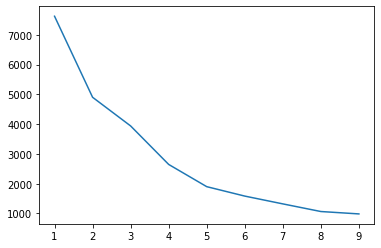

In [161]:
sns.lineplot(x=range(1,10),y=iner)

#### Let's use 5 clusters and fit the data

In [177]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(scl.fit_transform(train.loc[:,cols]))


### Create a column for cluster labels

In [178]:
train['clus']=kmeans.labels_

### Let's do some feature engineering for numerical columns

In [179]:
def feature_eng(df):

  numcols=['Number of speakers']

  grpcol=['clus'] 
  """group by numerical summary of each numerical column"""
  for valcol in numcols:
    df1=(df.groupby(grpcol)[valcol].
             agg({'min','median','mean','max',np.ptp,'std','var'}).reset_index())
    df1=(df1.rename(columns={c:valcol+'_'+c for c in df1.loc[:,df1.columns.str.
                                                match("(min|median|mean|max|ptp|std|var)")]}))
    df=pd.merge(df,df1,on=grpcol,how='left')
  return df  


  return df


In [180]:
train=feature_eng(train)

### Let's same pre-process task for the test data

In [181]:
test=pre_process(test)

In [182]:
test['clus']=kmeans.predict(scl.fit_transform(test.loc[:,cols]))

In [183]:
test=feature_eng(test)

### Let's create Xgboost classifier model

In [ ]:
!pip install -q optuna

In [152]:
from sklearn.model_selection import  cross_val_score,KFold,train_test_split,RepeatedStratifiedKFold,StratifiedKFold,learning_curve
import optuna
from optuna.samplers import RandomSampler,TPESampler,MOTPESampler,CmaEsSampler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier,plot_tree
import xgboost as xgb
from optuna.integration import XGBoostPruningCallback,LightGBMPruningCallback

In [ ]:
for i ,col in enumerate(train.columns):
  print(f"{i}_{col}")

### Label encode the target column.

In [111]:
lbl=LabelEncoder()

In [185]:
train['Degree of endangerment']=lbl.fit_transform(train['Degree of endangerment'])

### Split predictor and target variable

In [186]:
X=train.iloc[:,np.r_[0:507,508:517]]
y=train['Degree of endangerment']

In [ ]:
def objective(trial):
  skf = StratifiedKFold(n_splits=10,random_state=20,shuffle=True)
  for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    param = {
        "verbosity": 1,
        #"objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": trial.suggest_categorical("tree_method",['exact', 'approx', 'hist']),
        "eta": trial.suggest_float("eta", 0.000001, 1.0),

        #'interaction_constraints':[[2,3,8,12],[12,13,14],[5,6,9,12]],
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),

        "n_estimators":trial.suggest_int("n_estimators",100,1000)
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 20)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 30)
        
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-merror")
    xgb_clf=XGBClassifier(early_stopping_rounds=200,
                               
                              **param)
    xgb_clf.fit(X_train,y_train,
               eval_set=[(X_valid, y_valid)],
            eval_metric='merror',
            callbacks=[pruning_callback],
           
             )
    preds = xgb_clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    return accuracy


if __name__ == "__main__":
    study1 = optuna.create_study(direction='maximize',sampler=MOTPESampler(),
           pruner=optuna.pruners.SuccessiveHalvingPruner())
    study1.optimize(objective, n_trials=50)
    print('Number of finished trials:', len(study1.trials))
    print('Best trial:', study1.best_trial.params)  

In [188]:
print(f"{study1.best_value}, {study1.best_params}")

0.643979057591623, {'tree_method': 'exact', 'eta': 0.31663043255664886, 'booster': 'dart', 'lambda': 7.918702182728286e-06, 'alpha': 9.366571976455802e-05, 'subsample': 0.5186319222953145, 'colsample_bytree': 0.8752536482443778, 'n_estimators': 112, 'max_depth': 15, 'min_child_weight': 23, 'gamma': 2.884504582569639e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.01947872172155747, 'skip_drop': 5.1457671314054056e-08}


### Create model with tuned parameters

In [189]:
xgb_clf = XGBClassifier(early_stopping_rounds=200,
                        **study1.best_params)

### Fit the model

In [190]:
xgb_clf.fit(X,y,eval_metric='merror')

XGBClassifier(alpha=9.366571976455802e-05, booster='dart',
              colsample_bytree=0.8752536482443778, early_stopping_rounds=200,
              eta=0.31663043255664886, gamma=2.884504582569639e-06,
              grow_policy='depthwise', lambda=7.918702182728286e-06,
              max_depth=15, min_child_weight=23, n_estimators=112,
              normalize_type='forest', objective='multi:softprob',
              rate_drop=0.01947872172155747, sample_type='weighted',
              skip_drop=5.1457671314054056e-08, subsample=0.5186319222953145,
              tree_method='exact')

### Predict the test data

In [191]:
pred=xgb_clf.predict(test.loc[:,X.columns])

### Create result dataframe

In [192]:
res=pd.DataFrame({'Degree of endangerment':pred})

### Apply inverse label encoder

In [193]:
res['Degree of endangerment']=lbl.inverse_transform(res['Degree of endangerment'])

### Write the datafram to csv

In [194]:
res.to_csv("XGboost_Classifier_with_optuna_tuning.csv",index=False)